# Overview
This jupyter notebook contains the code I wrote to obtain the recommendations in the accompanying google doc called "KevinLuo_Trackman_Recs". The structure of this notebook is like this:
1. [Load Data](#Load-Data)
2. [Compute General Statistics](#Compute-General-Statistics)
4. [Pitch Performance by Zone Height](#Pitch-Performance-by-Zone-Height)

Additionally, I factored out much of the code functionality into individual functions placed in trackman_utils.py. Any function not defined in this notebook is defined in trackman_utils.py.

To run this notebook, you need to have the pybaseball library installed. To do this, simply run the following command: `pip install pybaseball`. Documentation for this library is [here](https://github.com/jldbc/pybaseball).

In [1]:
import pandas as pd
from pybaseball import statcast

from trackman_utils import *

## Load Data
This project uses two data sources: 
1. The csv provided by the questionnaire 
2. Statcast/Baseball Savant. I use the pybaseball library to scrape large chunks of data.
Some bits and pieces are manually from looking at Baseball Reference/Fangraphs (i.e. I got the average HR/9 rate from Baseball Reference).

I begin by scraping all events from the 2020 season using pybaseball:

In [2]:
# This may take 3 minutes or so
all_stats = statcast(start_dt='2020-07-22', end_dt='2020-11-01')
# convert from feet to inches
all_stats['pfx_x'] = all_stats.apply(lambda row: abs(row.pfx_x * 12), axis=1)
all_stats['pfx_z'] = all_stats.apply(lambda row: row.pfx_z * 12, axis=1)

This is a large query, it may take a moment to complete
Completed sub-query from 2020-07-22 to 2020-07-27
Completed sub-query from 2020-07-28 to 2020-08-02
Completed sub-query from 2020-08-03 to 2020-08-08
Completed sub-query from 2020-08-09 to 2020-08-14
Completed sub-query from 2020-08-15 to 2020-08-20
Completed sub-query from 2020-08-21 to 2020-08-26
Completed sub-query from 2020-08-27 to 2020-09-01
Completed sub-query from 2020-09-02 to 2020-09-07
Completed sub-query from 2020-09-08 to 2020-09-13
Completed sub-query from 2020-09-14 to 2020-09-19
Completed sub-query from 2020-09-20 to 2020-09-25
Completed sub-query from 2020-09-26 to 2020-10-01
Completed sub-query from 2020-10-02 to 2020-10-07
Completed sub-query from 2020-10-08 to 2020-10-13
Completed sub-query from 2020-10-14 to 2020-10-19
Completed sub-query from 2020-10-20 to 2020-10-25
Completed sub-query from 2020-10-26 to 2020-10-31
Completed sub-query from 2020-11-01 to 2020-11-01


Next, I load in the provided trackman csv and augment it with statistics I find informative. For example, using the 2020 Statcast wOBA weights I add in wOBA values for each entry:

In [3]:
df=pd.read_csv('~/Downloads/player_trackman.csv', sep=',')
print('dataset shape: ' + str(df.shape))

dataset shape: (2028, 31)


In [4]:
weights = {'Single': .9, 'Double': 1.25, 'Triple': 1.6, 'HomeRun': 2.0, 'Out': 0, 'Error': 0.9, 
           'FieldersChoice': 0, 'Sacrifice': 0, 'Strikeout': 0, 'Walk': .7}
denoms = {'Single': 1, 'Double': 1, 'Triple': 1, 'HomeRun': 1, 'Out': 1, 'Error': 1, 'FieldersChoice': 1, 
          'Sacrifice': 0, 'Strikeout': 1, 'Walk': 1}
df['woba_val'] = df.apply(parse_woba, weights=weights, axis=1)
df['woba_denom'] = df.apply(parse_woba_denom, denoms=denoms, axis=1)

## Compute General Statistics
In this section, I compute general metrics for Joe and compare him to league average.

In [6]:
num_batters = len(df[(df['k_or_bb']!="Undefined") | (df['pitch_call']=='InPlay')])
num_strikeouts = len(df[df['k_or_bb']=='Strikeout'])
num_walks = len(df[df['k_or_bb']=='Walk'])
whiffs = df[df['pitch_call']=='StrikeSwinging']
swings = df[df['pitch_call'].isin(['StrikeSwinging', 'InPlay', 'FoulBall'])]
whiff_rate = len(whiffs)/len(swings)
putaway_rate = num_strikeouts/len(df[df['strikes']==2])
homers = df[df['play_result']=='HomeRun']
outs = df[(df['k_or_bb']=='Strikeout') | (df['play_result'].isin(['Out', 'FieldersChoice', 'Sacrifice']))]
df_0str = df[df['strikes']==0]
df_1str = df[df['strikes']==1]
df_2str = df[df['strikes']==2]
fly_balls = len(df[df['hit_type']=='FlyBall'])
grounders = len(df[df['hit_type']=='GroundBall'])
popups = len(df[df['hit_type']=='Popup'])
ld = len(df[df['hit_type']=='LineDrive'])
total = fly_balls + grounders + popups + ld
hr_fb = len(homers)/fly_balls

print("number of batters faced: " + str(num_batters))
print("wOBA: " + str(df['woba_val'].sum()/df['woba_denom'].sum()))
print("number of strikeouts: " + str(num_strikeouts))
print("number of walks: " + str(num_walks))
print("K rate: " + str(num_strikeouts/num_batters))
print("BB rate: " + str(num_walks/num_batters))
print("K/BB ratio: " + str(num_strikeouts/num_walks))
print("whiff rate: " + str(whiff_rate))
print("putaway rate: " + str(putaway_rate))
print("HR/9: " + str(len(homers)/(len(outs)/27)))
print("0-strike wOBA: " + str(df_0str['woba_val'].sum()/df_0str['woba_denom'].sum()))
print("1-strike wOBA: " + str(df_1str['woba_val'].sum()/df_1str['woba_denom'].sum()))
print("2-strike wOBA: " + str(df_2str['woba_val'].sum()/df_2str['woba_denom'].sum()))
print('HR/FB: ' + str(hr_fb))
print('FB Rate: ' + str(fly_balls/total))
print('GB Rate: ' + str(grounders/total))
print('Popup Rate: ' + str(popups/total))
print('Line-Drive Rate: ' + str(ld/total))

number of batters faced: 518
wOBA: 0.34951361867704284
number of strikeouts: 113
number of walks: 46
K rate: 0.21814671814671815
BB rate: 0.0888030888030888
K/BB ratio: 2.4565217391304346
whiff rate: 0.26282051282051283
putaway rate: 0.18433931484502447
HR/9: 1.7267441860465116
0-strike wOBA: 0.40127118644067794
1-strike wOBA: 0.47109375
2-strike wOBA: 0.26865671641791045
HR/FB: 0.24719101123595505
FB Rate: 0.25
GB Rate: 0.4438202247191011
Popup Rate: 0.05898876404494382
Line-Drive Rate: 0.24719101123595505


In [7]:
lg_num_walks = len(all_stats[all_stats['events']=='walk'])
lg_num_strikeouts = len(all_stats[all_stats['events']=='strikeout'])
lg_appearances = len(all_stats[(all_stats['description'].isin(['hit_by_pitch','hit_into_play','hit_into_play_no_out',
 'hit_into_play_score'])) | (all_stats['events'].isin(['strikeout', 'walk']))])
lg_whiffs = len(all_stats[all_stats['description'].isin(['swinging_strike','swinging_strike_blocked'])])
lg_swings = len(all_stats[all_stats['description'].isin(['swinging_strike','swinging_strike_blocked',
                'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score', 'foul_tip', 'foul', 'foul_bunt'])])
lg_whiff_rate = lg_whiffs/lg_swings
all_stats_0str = all_stats[all_stats['strikes']==0]
all_stats_1str = all_stats[all_stats['strikes']==1]
all_stats_2str = all_stats[all_stats['strikes']==2]
lg_whiff_rate_2str = len(all_stats_2str[all_stats_2str['description'].isin([
    'swinging_strike','swinging_strike_blocked'])])/len(all_stats_2str[all_stats_2str['description'].isin(['swinging_strike','swinging_strike_blocked',
                'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score', 'foul_tip', 'foul', 'foul_bunt'])])
lg_putaways = len(all_stats_2str[all_stats_2str['description'].isin(['swinging_strike','swinging_strike_blocked', 
                                                                     'called_strike'])])
lg_putaway_rate = lg_putaways/len(all_stats_2str)

print("number completed at-bats across league: " + str(lg_appearances))
print("League wOBA: " + str(all_stats['woba_value'].sum()/all_stats['woba_denom'].sum()))
print("League BB rate: " + str(lg_num_walks/lg_appearances))
print("League K rate: " + str(lg_num_strikeouts/lg_appearances))
print("League whiff rate: " + str(lg_whiff_rate))
print("League whiff rate on 2 strikes: " + str(lg_whiff_rate_2str))
print("League putaway rate: " + str(lg_putaway_rate))
print("League 0-strike wOBA: " + str(all_stats_0str['woba_value'].sum()/all_stats_0str['woba_denom'].sum()))
print("League 1-strike wOBA: " + str(all_stats_1str['woba_value'].sum()/all_stats_1str['woba_denom'].sum()))
print("League 2-strike wOBA: " + str(all_stats_2str['woba_value'].sum()/all_stats_2str['woba_denom'].sum()))

number completed at-bats across league: 70225
League wOBA: 0.33160621761658027
League BB rate: 0.08909932360270559
League K rate: 0.23598433606265576
League whiff rate: 0.24746359119833206
League whiff rate on 2 strikes: 0.23859677715077313
League putaway rate: 0.18805360530736046
League 0-strike wOBA: 0.4424196072851451
League 1-strike wOBA: 0.43137717403660336
League 2-strike wOBA: 0.24491574209755074


Below, I break down how each of Joe's pitches fares. I do the same for league average to get a sense of comparison. For each pitch type, I compute key stats like whiff rate and frequency.

In [8]:
# for each pitch type, compute the number of times each pitch_call occurs.
calls_by_pitch = df.groupby(['tagged_pitch_type', 'pitch_call']).size()
calls_by_pitch_0str = df[df['strikes']==0].groupby(['tagged_pitch_type', 'pitch_call']).size()
calls_by_pitch_1str = df[df['strikes']==1].groupby(['tagged_pitch_type', 'pitch_call']).size()
calls_by_pitch_2str = df[df['strikes']==2].groupby(['tagged_pitch_type', 'pitch_call']).size()

In [9]:
pt = df.groupby('tagged_pitch_type').mean()
pt['num_pitches'] = df.groupby('tagged_pitch_type').count()['rel_speed']
pt['frequency'] = df.groupby('tagged_pitch_type').count()['rel_speed']/df.groupby('tagged_pitch_type').count()['rel_speed'].sum()
pt['2str_prop'] = pt.apply(parse_prop, df=df_2str, axis=1)
pt_sums = df.groupby('tagged_pitch_type').sum()
pt['woba'] = pt_sums['woba_val']/pt_sums['woba_denom']
pt['whiff_rate'] = pt.apply(parse_whiff, calls_by_pitch=calls_by_pitch, axis=1)
pt['whiff_rate_0str'] = pt.apply(parse_whiff, calls_by_pitch=calls_by_pitch_0str, axis=1)
pt['whiff_rate_1str'] = pt.apply(parse_whiff, calls_by_pitch=calls_by_pitch_1str, axis=1)
pt['whiff_rate_2str'] = pt.apply(parse_whiff, calls_by_pitch=calls_by_pitch_2str, axis=1)
pt['putaway_rate'] = pt.apply(parse_putaway, calls_by_pitch=calls_by_pitch_2str, axis=1)

In [10]:
all_calls_by_pitch_2str = all_stats[all_stats['strikes']==2].groupby(['pitch_type', 'description']).size()
pt_all = all_stats.groupby('pitch_type').mean()
pt_all['whiff_rate'] = pt_all.apply(parse_whiff_statcast, all_stats=all_stats, axis=1)
pt_all['putaway_rate'] = pt_all.apply(parse_putaway, calls_by_pitch=all_calls_by_pitch_2str, statcast=True, axis=1)
pt_all['2str_prop'] = pt_all.apply(parse_prop, df=all_stats_2str, statcast=True, axis=1)

Visualize Joe's performance per-pitch. Scroll right on table to see full info. Observe how Joe's curveball, slider and changeup get very good whiff rates.

In [11]:
pt[['frequency', 'num_pitches', 'rel_speed', 'spin_rate', 'induced_vert_break', 'horz_break', 'strike_prob', 
    'exit_speed', 'angle', 'woba', 'whiff_rate', 'putaway_rate', '2str_prop']].drop(index=['Undefined', 'Sinker'])

,frequency,num_pitches,rel_speed,spin_rate,induced_vert_break,horz_break,strike_prob,exit_speed,angle,woba,whiff_rate,putaway_rate,2str_prop
tagged_pitch_type,,,,,,,,,,,,,
ChangeUp,0.185094,375,83.852181,1599.472751,4.168575,14.188447,0.365101,84.164668,4.180917,0.383505,0.380435,0.190083,0.197390
Curveball,0.136723,277,80.301658,2291.708923,-14.527425,-7.645178,0.261175,82.981064,-4.978477,0.204464,0.516484,0.270270,0.181077
Fastball,0.560711,1136,94.205499,2318.137315,14.036425,10.470987,0.546449,87.042832,19.645526,0.373026,0.157221,0.147059,0.499184
Slider,0.115992,235,86.414234,2198.643612,2.878261,-1.136485,0.404706,85.537730,12.056047,0.320000,0.383929,0.202703,0.120718


Compare Joe's per-pitch performance to league average.

In [12]:
pt_all[['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z', 'whiff_rate', 'putaway_rate', '2str_prop']]

,release_speed,release_spin_rate,pfx_x,pfx_z,whiff_rate,putaway_rate,2str_prop
pitch_type,,,,,,,
CH,84.524014,1767.870356,13.430731,6.893531,0.302907,0.189440,0.123814
CS,74.129016,2383.108808,10.371606,-8.189845,0.289855,0.203390,0.000713
CU,78.535243,2541.587673,9.538011,-8.260096,0.311735,0.204703,0.107911
FC,88.271527,2388.458587,3.385959,7.904931,0.237800,0.186266,0.058777
FF,93.441788,2309.996230,7.293938,16.020979,0.200605,0.171167,0.326236
FO,87.933333,2082.000000,16.400000,11.840000,0.000000,NaN,0.000000
FS,85.232868,1470.582999,11.178947,4.985694,0.335234,0.209677,0.023226
KC,81.541420,2552.697778,7.420070,-10.769674,0.332471,0.225140,0.028071
KN,59.760870,2796.260870,5.947826,4.142609,0.111111,0.090909,0.000133


Curveball looks like it can be really good (.202 woba, negative launch angle). Other pitches have struggling woba; but the curveball, changeup, and slider all have good whiff rates. Fastball's whiff rate is really bad compared to league average (league average around 28% in 2015). Throw fastball less as a start?

In a hypothetical world, he has the following pitch distribution during 2 strikes: FB=0.35, CU=0.33, CH=0.2, SL=0.12. Assuming same per-pitch putaway rate, new putaway% = 0.35(0.147)+0.33(0.27)+0.2(0.19)+0.12(0.203)=20.2%!. So we would get above average putaway rate with that (about 65nd percentile).

With 613 2-strike opportunities and a 18.4% putaway rate, he strikes out 112.792 batters.
If we assume he creates the same number of opportunities and a 20.2% putaway rate, he strikes out 124 batters. Assuming he still faces 518 batters, this yields a 23.96% K rate which is in the 55th percentile.

Compute the percentiles that Joe falls in for key stats.

In [13]:
group_by_pitcher = all_stats.groupby('pitcher')
stats_by_pitcher = group_by_pitcher.apply(agg_statcast_pitchers, min_batters_faced=50).dropna()
print("Number qualified pitchers: " + str(len(stats_by_pitcher)))

Number qualified pitchers: 476


In [14]:
print('Putaway=.184 Percentile: ' + str(percentile(0.184, stats_by_pitcher, 'putaway_rate')))
print('Putaway=.202 Percentile: ' + str(percentile(0.202, stats_by_pitcher, 'putaway_rate')))
print('\n')
print('K=.218 Percentile: ' + str(percentile(0.218, stats_by_pitcher, 'k_rate')))
print('K=.2396 Percentile: ' + str(percentile(0.2396, stats_by_pitcher, 'k_rate')))
print('\n')
print('Whiff=.263 Percentile: ' + str(percentile(0.263, stats_by_pitcher, 'whiff_rate')))
print('BB=.089 Percentile: ' + str(1-percentile(0.089, stats_by_pitcher, 'bb_rate')))
print('wOBA=.350 Percentile: ' + str(1-percentile(0.350, stats_by_pitcher, 'woba')))

Putaway=.184 Percentile: 0.48739495798319327
Putaway=.202 Percentile: 0.6491596638655462


K=.218 Percentile: 0.4117647058823529
K=.2396 Percentile: 0.5462184873949579


Whiff=.263 Percentile: 0.6218487394957983
BB=.089 Percentile: 0.48109243697478987
wOBA=.350 Percentile: 0.3382352941176471


Joe was tagged for 22 homers during this season; 16 of those were off of fastballs, i.e. 73%. Throwing less fastballs probably lowers his HR/9.

In [15]:
homers = df[df['play_result']=='HomeRun']
homers.groupby('tagged_pitch_type').size()

tagged_pitch_type
ChangeUp      3
Curveball     1
Fastball     16
Slider        2
dtype: int64

In fact, 13/22 = 59% of the homers were hit off of fastballs during 0-strike or 1-strike counts. Having a more diverse pitch mix during such counts as suggested will ease the home run burden. 

In [16]:
homers.groupby(['tagged_pitch_type', 'strikes']).size()

tagged_pitch_type  strikes
ChangeUp           0          1
                   2          2
Curveball          0          1
Fastball           0          6
                   1          7
                   2          3
Slider             0          1
                   2          1
dtype: int64

## Pitch Performance by Zone Height
In this section, I visualize how each of Joe's pitches does by zone height. For each pitch and zone height, I plot the pitches and print key metrics (whiff%, clean%, etc). Universal strike zone parameters are from [here](https://www.baseballprospectus.com/news/article/40891/prospectus-feature-the-universal-strike-zone/).


INFO FOR Fastball at (-100, 2.2)
Fastball clean rate: 0.15384615384615385
Fastball whiff rate: 0.0
Fastball whiffs: 0
Fastball called strikes: 8
Fastball swings: 23
Fastball strikes: 20
Fastball chances: 52


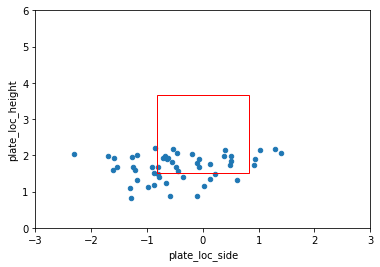


INFO FOR Fastball at (2.2, 2.8)
Fastball clean rate: 0.06557377049180328
Fastball whiff rate: 0.08695652173913043
Fastball whiffs: 4
Fastball called strikes: 0
Fastball swings: 46
Fastball strikes: 36
Fastball chances: 61


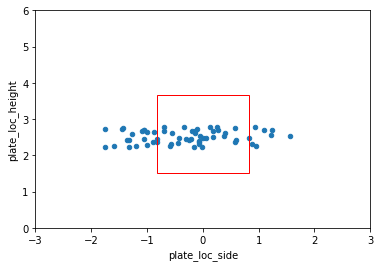


INFO FOR Fastball at (2.8, 100)
Fastball clean rate: 0.17098445595854922
Fastball whiff rate: 0.30851063829787234
Fastball whiffs: 29
Fastball called strikes: 4
Fastball swings: 94
Fastball strikes: 80
Fastball chances: 193


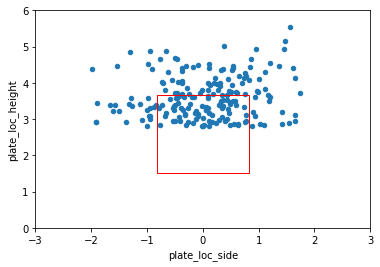

frequencies for Fastball by height: {(-100, 2.2): 0.16993464052287582, (2.2, 2.8): 0.19934640522875818, (2.8, 100): 0.630718954248366}

INFO FOR ChangeUp at (-100, 2.2)
ChangeUp clean rate: 0.24719101123595505
ChangeUp whiff rate: 0.3448275862068966
ChangeUp whiffs: 20
ChangeUp called strikes: 2
ChangeUp swings: 58
ChangeUp strikes: 26
ChangeUp chances: 89


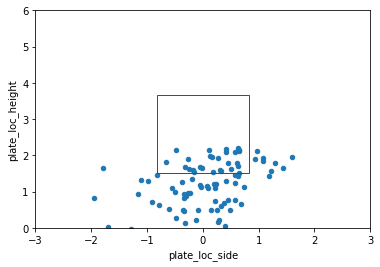


INFO FOR ChangeUp at (2.2, 2.8)
ChangeUp clean rate: 0.0
ChangeUp whiff rate: 0.0
ChangeUp whiffs: 0
ChangeUp called strikes: 0
ChangeUp swings: 15
ChangeUp strikes: 12
ChangeUp chances: 17


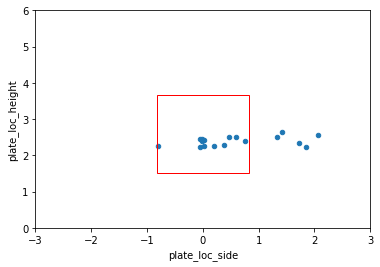


INFO FOR ChangeUp at (2.8, 100)
ChangeUp clean rate: 0.06666666666666667
ChangeUp whiff rate: 0.2
ChangeUp whiffs: 1
ChangeUp called strikes: 0
ChangeUp swings: 5
ChangeUp strikes: 4
ChangeUp chances: 15


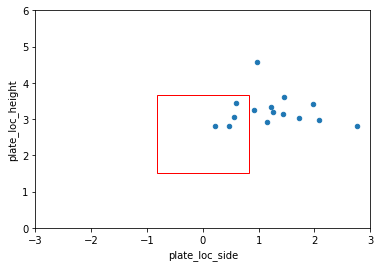

frequencies for ChangeUp by height: {(-100, 2.2): 0.7355371900826446, (2.2, 2.8): 0.14049586776859505, (2.8, 100): 0.12396694214876033}

INFO FOR Slider at (-100, 2.2)
Slider clean rate: 0.20754716981132076
Slider whiff rate: 0.4166666666666667
Slider whiffs: 10
Slider called strikes: 1
Slider swings: 24
Slider strikes: 13
Slider chances: 53


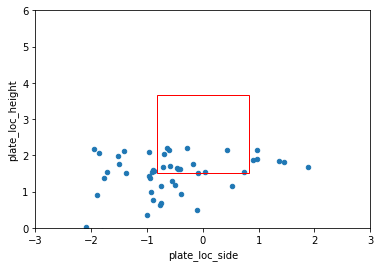


INFO FOR Slider at (2.2, 2.8)
Slider clean rate: 0.18181818181818182
Slider whiff rate: 0.2222222222222222
Slider whiffs: 2
Slider called strikes: 0
Slider swings: 9
Slider strikes: 8
Slider chances: 11


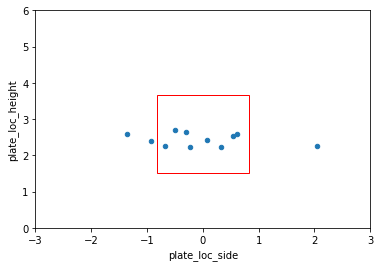


INFO FOR Slider at (2.8, 100)
Slider clean rate: 0.2
Slider whiff rate: 0.2857142857142857
Slider whiffs: 2
Slider called strikes: 0
Slider swings: 7
Slider strikes: 7
Slider chances: 10


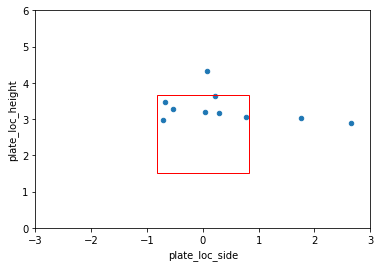

frequencies for Slider by height: {(-100, 2.2): 0.7162162162162162, (2.2, 2.8): 0.14864864864864866, (2.8, 100): 0.13513513513513514}

INFO FOR Curveball at (-100, 2.2)
Curveball clean rate: 0.29213483146067415
Curveball whiff rate: 0.5111111111111111
Curveball whiffs: 23
Curveball called strikes: 3
Curveball swings: 45
Curveball strikes: 17
Curveball chances: 89


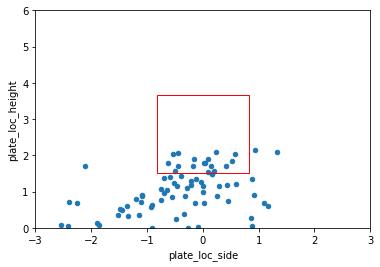


INFO FOR Curveball at (2.2, 2.8)
Curveball clean rate: 0.25
Curveball whiff rate: 0.125
Curveball whiffs: 1
Curveball called strikes: 2
Curveball swings: 8
Curveball strikes: 6
Curveball chances: 12


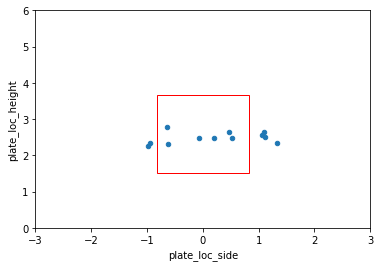


INFO FOR Curveball at (2.8, 100)
Curveball clean rate: 0.1
Curveball whiff rate: 0.0
Curveball whiffs: 0
Curveball called strikes: 1
Curveball swings: 1
Curveball strikes: 1
Curveball chances: 10


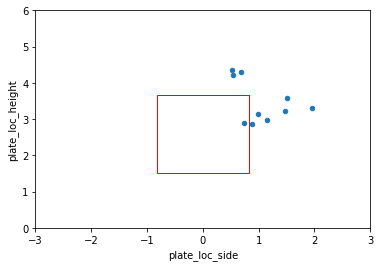

frequencies for Curveball by height: {(-100, 2.2): 0.8018018018018018, (2.2, 2.8): 0.10810810810810811, (2.8, 100): 0.09009009009009009}


In [17]:
# look at 2-strike pitches exclusively
heights = [(-100, 2.2), (2.2, 2.8), (2.8, 100)]
whiff_by_height(['Fastball', 'ChangeUp', 'Slider', 'Curveball'], df_2str, heights, putaway=True)

The slider and change both have better whiff rates in the middle of the zone than the fastball (2x). Clean rate is better too. Possible that if Joe needs to throw a strike, he should throw one of these with higher frequency.

Curve down is killer; Curve middle and up doesn't get as many whiffs but gets many called strikes.


INFO FOR Fastball at (-100, 2.2)
Fastball clean rate: 0.30132450331125826
Fastball whiff rate: 0.07407407407407407
Fastball whiffs: 8
Fastball called strikes: 83
Fastball swings: 108
Fastball strikes: 159
Fastball chances: 302


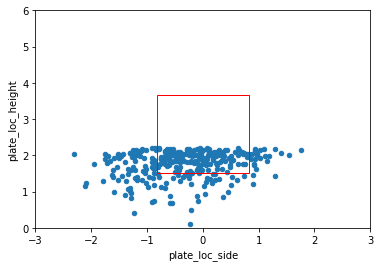


INFO FOR Fastball at (2.2, 2.8)
Fastball clean rate: 0.30340557275541796
Fastball whiff rate: 0.10309278350515463
Fastball whiffs: 20
Fastball called strikes: 78
Fastball swings: 194
Fastball strikes: 238
Fastball chances: 323


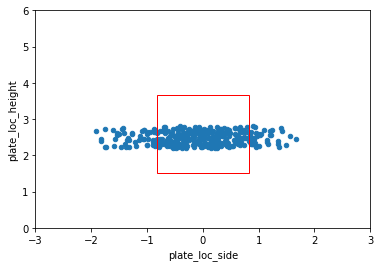


INFO FOR Fastball at (2.8, 100)
Fastball clean rate: 0.2172211350293542
Fastball whiff rate: 0.23673469387755103
Fastball whiffs: 58
Fastball called strikes: 53
Fastball swings: 245
Fastball strikes: 279
Fastball chances: 511


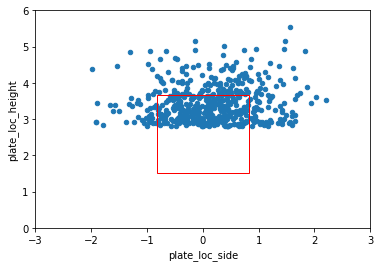

frequencies for Fastball by height: {(-100, 2.2): 0.2658450704225352, (2.2, 2.8): 0.28433098591549294, (2.8, 100): 0.4498239436619718}

INFO FOR ChangeUp at (-100, 2.2)
ChangeUp clean rate: 0.3155737704918033
ChangeUp whiff rate: 0.45384615384615384
ChangeUp whiffs: 59
ChangeUp called strikes: 18
ChangeUp swings: 130
ChangeUp strikes: 70
ChangeUp chances: 244


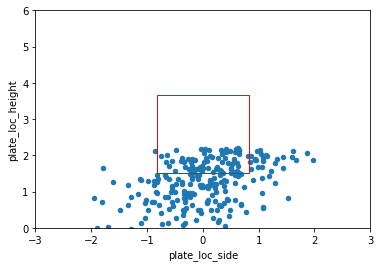


INFO FOR ChangeUp at (2.2, 2.8)
ChangeUp clean rate: 0.2972972972972973
ChangeUp whiff rate: 0.18181818181818182
ChangeUp whiffs: 8
ChangeUp called strikes: 14
ChangeUp swings: 44
ChangeUp strikes: 51
ChangeUp chances: 74


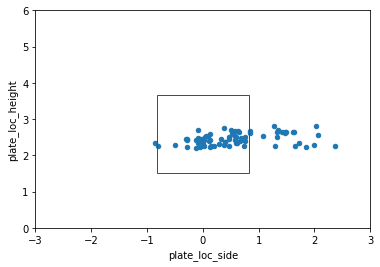


INFO FOR ChangeUp at (2.8, 100)
ChangeUp clean rate: 0.15789473684210525
ChangeUp whiff rate: 0.3
ChangeUp whiffs: 3
ChangeUp called strikes: 6
ChangeUp swings: 10
ChangeUp strikes: 12
ChangeUp chances: 57


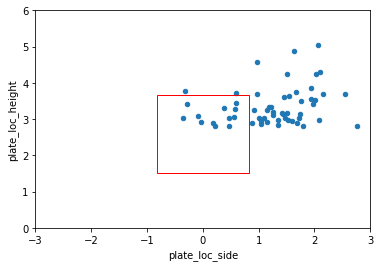

frequencies for ChangeUp by height: {(-100, 2.2): 0.6506666666666666, (2.2, 2.8): 0.19733333333333333, (2.8, 100): 0.152}

INFO FOR Slider at (-100, 2.2)
Slider clean rate: 0.2804878048780488
Slider whiff rate: 0.4931506849315068
Slider whiffs: 36
Slider called strikes: 10
Slider swings: 73
Slider strikes: 41
Slider chances: 164


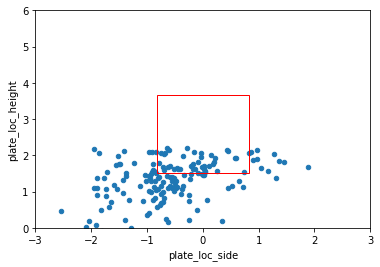


INFO FOR Slider at (2.2, 2.8)
Slider clean rate: 0.40425531914893614
Slider whiff rate: 0.14285714285714285
Slider whiffs: 4
Slider called strikes: 15
Slider swings: 28
Slider strikes: 35
Slider chances: 47


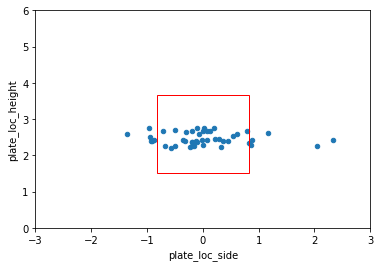


INFO FOR Slider at (2.8, 100)
Slider clean rate: 0.3333333333333333
Slider whiff rate: 0.2727272727272727
Slider whiffs: 3
Slider called strikes: 5
Slider swings: 11
Slider strikes: 15
Slider chances: 24


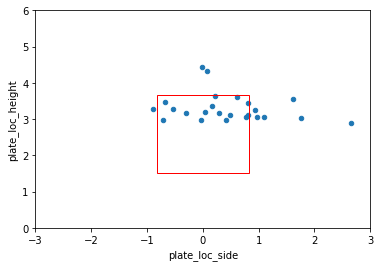

frequencies for Slider by height: {(-100, 2.2): 0.6978723404255319, (2.2, 2.8): 0.2, (2.8, 100): 0.10212765957446808}

INFO FOR Curveball at (-100, 2.2)
Curveball clean rate: 0.3349282296650718
Curveball whiff rate: 0.5769230769230769
Curveball whiffs: 45
Curveball called strikes: 25
Curveball swings: 78
Curveball strikes: 44
Curveball chances: 209


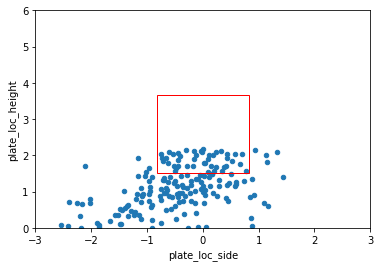


INFO FOR Curveball at (2.2, 2.8)
Curveball clean rate: 0.46875
Curveball whiff rate: 0.18181818181818182
Curveball whiffs: 2
Curveball called strikes: 13
Curveball swings: 11
Curveball strikes: 18
Curveball chances: 32


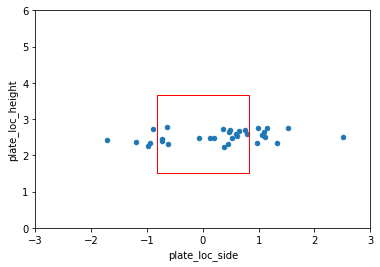


INFO FOR Curveball at (2.8, 100)
Curveball clean rate: 0.19444444444444445
Curveball whiff rate: 0.0
Curveball whiffs: 0
Curveball called strikes: 7
Curveball swings: 2
Curveball strikes: 10
Curveball chances: 36


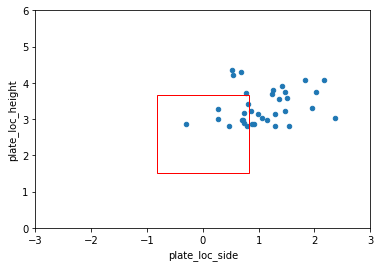

frequencies for Curveball by height: {(-100, 2.2): 0.7545126353790613, (2.2, 2.8): 0.11552346570397112, (2.8, 100): 0.1299638989169675}


In [18]:
# look at all pitches
heights = [(-100, 2.2), (2.2, 2.8), (2.8, 100)]
whiff_by_height(['Fastball', 'ChangeUp', 'Slider', 'Curveball'], df, heights)